In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import keras as k

Using TensorFlow backend.


# Train a Convolutional Neural Network to Classify MNIST

**Why not just rearrange our image as a big long vector and use a normal neural network?**
Usually features in an image are spread over neigbouring pixels, if we scan a 2D image with a filter then we'll capture those clustered features which might be missed when reshaping the image into a long vector.

1. Load data
2. Define model
3. Train model
4. Evaluate who well it performs
5. Use the model on our own data

## 1. Load data

In [2]:
(x_train, y_train), (x_test, y_test) = k.datasets.mnist.load_data()

Let's look at what we just loaded:

In [3]:
print('x_train: {}'.format(x_train.shape),
      'y_train: {}'.format(y_train.shape),
      'x_test: {}'.format(x_test.shape),
      'y_test: {}'.format(y_test.shape)
     )

x_train: (60000, 28, 28) y_train: (60000,) x_test: (10000, 28, 28) y_test: (10000,)


``x_train`` - We have 60,000 (28x28) images of handwritten digits to train the classifier.

``y_train`` - There are 60,000 corresponding labels which tell us which number is represented in the image.

``x_test`` - These 10,000 images are not used for training. We'll keep these to test how good our model is at predicting the number in some **unseen** images.

``y_test`` - Corresponding labels for the x_test images. We'll use these as a ground truth to check how many of the test images our model guessed correctly.

Lets have a look at the first 25 images in the training set, we'll use the ``y_train`` labels as titles to the images:

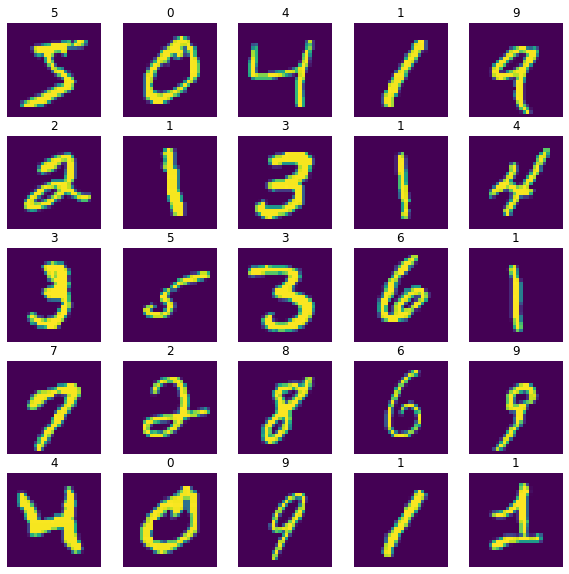

In [4]:
plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.imshow(x_train[i,:,:])
    plt.title('{}'.format(y_train[i]))
    plt.axis('off')

# 2. Define a model

First we need to use tensorflow to make a network, we'll call it ``model``:

In [5]:
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense

model = k.Sequential([
    Conv2D(20, (3,3), padding='same', activation=tf.nn.relu, input_shape=(28, 28, 1)),
    MaxPooling2D((2, 2), strides=2),
    Conv2D(40, (3,3), padding='same', activation=tf.nn.relu),
    MaxPooling2D((2, 2), strides=2),
    Flatten(),    
    Dense(80, activation=tf.nn.relu),
    Dense(10,  activation=tf.nn.softmax)
])


### Let's break it down:

Model specs:
- ``Sequential`` So that each layer will pass into the next layer 
- ``Conv2D`` The 1st layer is has ``20`` ``(3,3)`` convolutional filters (sometimes referred to as kernels) which will each scan over our image like this: <img src="https://miro.medium.com/max/790/1*1okwhewf5KCtIPaFib4XaA.gif" width="200" align="center"> 
<center><em>The image (blue), is scanned with a (3x3) filter (grey) and the output <br>of each of the filters will produce 20 feature maps of the image (green).</em></center>
<br>
<br>
- ``padding`` Notice that there needs to be padding added around our image for the scan to work at the edges. Using the ``same`` argument will make sure that our feature maps are the same size as our input image to the layer.
- ``activation`` All our 20 feature maps have 28x28 pixels. Each feature map has a weight which will multiply all the pixels by the same number, this is a learned weight because some maps will more important for the task than others. Then all the feature maps are summed pixel-wise and each pixel will act as a node with an activation function. In this case the simple but very effective non-linear ``relu`` function (below).

<img src="https://miro.medium.com/max/2052/1*DfMRHwxY1gyyDmrIAd-gjQ.png" width="400">

- ``input_shape`` This will be the dimensions of our image. Notice we added an extra dimension on the end, this is because the model will eventually store all the feature maps in this dimension so we'll need to add a dimension to our training and test input data. Luckily there's an easy way to do that: 

In [6]:
x_train = x_train.reshape(-1, 28, 28, 1)
x_test = x_test.reshape(-1, 28, 28, 1)

print('x_train: {}'.format(x_train.shape))
print('x_test : {}'.format(x_test.shape))

x_train: (60000, 28, 28, 1)
x_test : (10000, 28, 28, 1)


- ``MaxPooling`` - The 2nd layer in our model is a dimensionality reduction. This scans a filter with shape ``(2,2)``over the output from the ``Conv2D`` layer and simply takes the maximum value of every step to be the downsampled pixel value. The ``strides`` argument just tells the filter how many pixels to step along during the scan. <img src="https://www.oreilly.com/radar/wp-content/uploads/sites/3/2019/06/Figure_4-87c227113cdd0b73d842267404d4aa00.gif" width="400"> <center><em>Max-pooling by scanning a 2x2 filter in strides of 2 pixels to <br>downsample the output of the previous layer</em></center>

- The next layer doubles the number of filters and feature maps to ``40`` and downsamples the image size again with another ``MaxPooling`` layer. Usually the first layer will capture basic features such as edges and fundamental shapes in the input, as we progress through the layers, there are a lot more features we're looking for which are more complex and intricate, this is why the number of filters is increased.

- ``Flatten`` The 5th layer in the model will take the output of layer 4 and arrange it as a long 1D vector so we can use a fully connected neural network to do the classification task.
- ``Dense`` The penultimate layer will use 80 fully connected neurons and the output of the convolutional feature extraction and learn which features correspond to the labels.
- ``softmax`` Notice that we're using a different activation function in the final layer, this will normalise all the outputs to sum=1 so we get a **probability** of being each class instead of looking for the largest number.
- You should also take note that we only have 10 nodes in the last layer, we can't really change this because there are only 10 different options in our labels:

labels --> [0,9]


<BarContainer object of 10 artists>

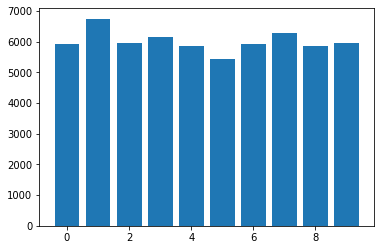

In [7]:
print('labels --> [{},{}]'.format(y_train.min(), y_train.max()))

# plot the labels as a histogram to visualise 10 different possibilities
hist = np.histogram(y_train, bins=np.arange(11))
plt.bar(hist[1][:-1], hist[0])

### Get tensorflow to summarise what we've built (great for trouble shooting errors!):

In [8]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 28, 28, 20)        200       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 14, 14, 20)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 14, 14, 40)        7240      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 7, 7, 40)          0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 1960)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 80)                156880    
_________________________________________________________________
dense_2 (Dense)              (None, 10)               

# 3. Train the model

### First we need to compile the model and choose the hyper-parameters

In [9]:
model.compile(optimizer='Adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy']
             )
print('Compiled! Ready to start training..')

Compiled! Ready to start training..


 - ``optimizer`` We're using gradient descent so the step we take in the gradient direction on each iteration needs to be determined. In this case we're using a technique developed in http://arxiv.org/abs/1412.6980 to efficiently solve the problem. There are lots of optimizers to try:
     - Adadelta
     - Adagrad
     - Adam
     - Adamax
     - Nadam
     - RMSprop
     - SGD
     
 - ``loss`` This is the objective function we're minimising. using ``sparse_categorical_crossentropy`` will compare the probability outcome of our model with the real result to minimise the difference in pobability distribution. The sparse part is just because our ``y_train`` and ``y_test`` data is integers rather than how the output nodes are arranged as a string of ones and zeros.
 
 - ``metrics`` We want to monitor how well the model is doing and ``['accuracy']`` will report the percentage of correct predictions as an output when we're training and testing.

### Train the model with the training data

In [10]:
model.fit(x_train, y_train,
          epochs=10,
          batch_size=30,
          shuffle='True'
         )

Epoch 1/10
60000/60000 [==============================] - 10s 165us/step - loss: 0.2903 - accuracy: 0.9421
Epoch 2/10
60000/60000 [==============================] - 6s 101us/step - loss: 0.0638 - accuracy: 0.9808
Epoch 3/10
60000/60000 [==============================] - 6s 100us/step - loss: 0.0486 - accuracy: 0.9848
Epoch 4/10
60000/60000 [==============================] - 6s 106us/step - loss: 0.0415 - accuracy: 0.9869
Epoch 5/10
60000/60000 [==============================] - 6s 100us/step - loss: 0.0356 - accuracy: 0.9890
Epoch 6/10
60000/60000 [==============================] - 6s 98us/step - loss: 0.0298 - accuracy: 0.9911
Epoch 7/10
60000/60000 [==============================] - 6s 100us/step - loss: 0.0260 - accuracy: 0.9920
Epoch 8/10
60000/60000 [==============================] - 6s 99us/step - loss: 0.0213 - accuracy: 0.9935
Epoch 9/10
60000/60000 [==============================] - 6s 98us/step - loss: 0.0207 - accuracy: 0.9939
Epoch 10/10
60000/60000 [=======================

- ``epochs`` The number of times the entire training data is passed throught the model
- ``batch_size`` Calculating the gradient for the entire 60,000 training images and labels at once is computationally expensive, so we break it up into chunks of 30 instead. Calculating the gradient 2,000 times on chunks of 30 is much quicker and we can optimise the computer hardware to accelerate the training.
- ``shuffle`` The training set is already shuffled in our case so that we don't introduce the images in order as we train. However, the shuffle parameter will re-shuffle the order of the training data on every epoch so that we'll train with different mini-batches every iteration.

# 4. Evaluate the model
Now we test the performance on our unseen test data:

In [11]:
results = model.evaluate(x_test, y_test)

print('loss: {:.3f}, acc: {:.3f}'.format(results[0],results[1]))

10000/10000 [==============================] - 1s 61us/step
loss: 0.055, acc: 0.988


- ``evaluate`` Takes all our 10,000 test images and compares the prediction with the ground truth. Our model got 98.3% of the test images correct.

Now lets **use** the model!

Our model guessed: 3


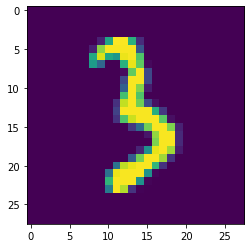

In [12]:
example_image = 44

predict = model.predict(x_test[example_image:example_image+1])

plt.imshow(x_test[example_image,:,:,0])
print('Our model guessed: {}'.format(np.argmax(predict)))

Try changing the ``test_image`` variable above to be a number between 0 and 100. 

In the example above, we're taking the most likely result using the ``np.argmax()`` function but because we trained using ``softmax`` in the output then we can also see the probability of being another class:

 Here is the full prediction probability for all classes: 
[[1.0495184e-16 6.1777097e-11 2.2510580e-09 9.9999976e-01 5.6277794e-10
  1.4676063e-07 3.8419261e-11 2.4688493e-09 5.8058315e-08 1.6516751e-09]]


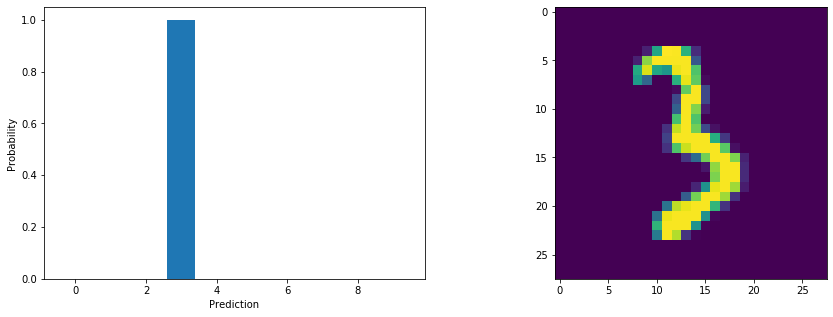

In [13]:
# note: Using \033[1m just makes the text bold
print('\033[1m Here is the full prediction probability\
 for all classes:\033[0m \n{}'.format(predict))

def plot_results(img, prediction):
    # Make a subplot showing full prediction
    # alongside the example image
    
    plt.figure(figsize=(15,5))
    plt.subplot(1,2,1)
    plt.bar(np.arange(10), prediction)
    plt.xlabel('Prediction')
    plt.ylabel('Probability')

    plt.subplot(1,2,2)
    plt.imshow(img)

img = x_test[example_image,:,:,0]
prediction = predict[0]

plot_results(img, prediction)

# 5. Using our own data

Let's make our own image and see how well the model predicts the value!

Visit: https://jspaint.app/
Follow these instructions:
- Hit **"fill"** and click anywhere on the blank image to make it black
- Go to the toolbar at the top and click: **"Image" -> "Attributes"**
- Set size to be **28x28 pixel units** and select **black & white** colours with **opaque** transparency
- Hit **"okay"**
- Back to the toolbar and select: **"View" -> "Zoom" -> "Zoom to Window"
- Now select the **Paintbrush** and select the **color white** at the bottom of the screen
- Use the left panel to change the brush **size** to be the **smallest**
- Draw a number between 0 and 9
- **File -> Save** should download the image

<!-- <iframe src="https://giphy.com/embed/hsVJnBeR6wpMkiB313" width="480" height="270" frameBorder="0" class="giphy-embed" allowFullScreen></iframe><p><a href="https://giphy.com/gifs/hsVJnBeR6wpMkiB313">via GIPHY</a></p> -->

<img src="https://github.com/slack-a-jack/ml-getting-started/blob/master/Make%20mnist.gif?raw=true" width="800" align="center">



 ### Now upload it using cv2:

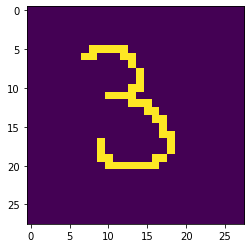

In [14]:
import cv2

# You'll need to use your own file path for your computer!
# It will be pretty close to what I've written below
filename='C:/Users/jack/Downloads/untitled (1).png'

my_img = cv2.imread(filename, 0)

plt.imshow(my_img)

 If it worked, you should see your image!
 
 If you get a **"module not found"** error here then you need to go to anaconda prompt, activate your environment and type ``conda install opencv``. See the first tutorial on getting stuff downloaded for more info on how to do this)
 
 Now we'll use the predict function to see what our classifier thinks it is:

[2.6573254e-18 1.2759835e-11 6.6992381e-13 1.0000000e+00 2.6139660e-23
 9.9443431e-09 5.3050621e-18 1.6641110e-18 1.5087309e-14 5.5081517e-17]


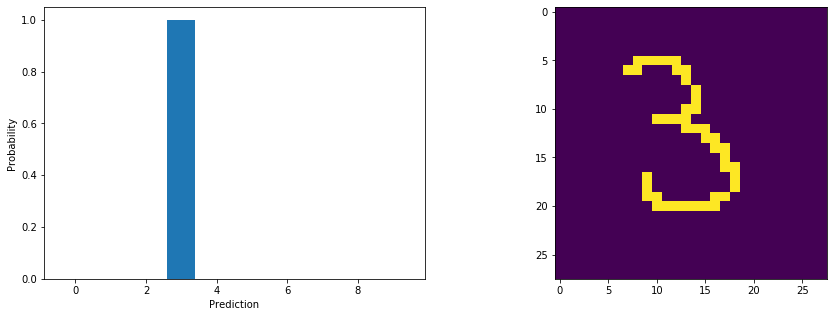

In [15]:
# Remember we need to have all the correct dimensions
my_img_reshaped = np.zeros((1, 28, 28, 1))
my_img_reshaped[0,:,:,0] = my_img

# the predict function is an array of an array 
# so that multiple predctions can be made at once.
# We only have one prediction here so I've taken the
# zeroth element by adding the [0] at the end.
predict_my_img = model.predict(my_img_reshaped)[0]

plot_results(my_img, predict_my_img)
print(predict_my_img)

### Try draw an image which looks difficult and try and fool the classifier

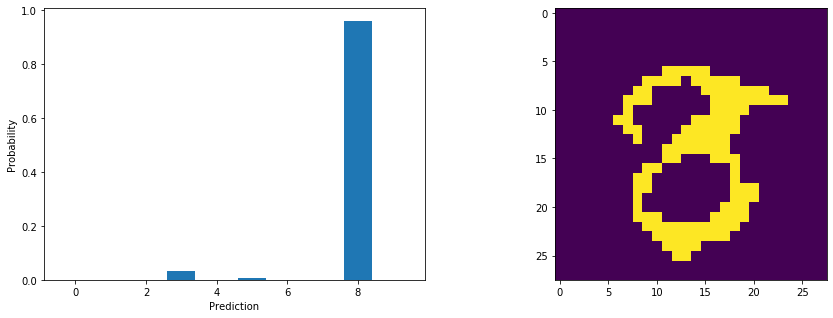

In [16]:
# You'll need to use your own file path for your computer!
# It will be pretty close to what I've written below
filename='C:/Users/jack/Downloads/untitled (10).png'
my_img = cv2.imread(filename, 0)

# Remember we need to have all the correct dimensions
my_img_reshaped = np.zeros((1, 28, 28, 1))
my_img_reshaped[0,:,:,0] = my_img

# the predict function is an array of an array 
# so that multiple predctions can be made at once.
# We only have one prediction here so I've taken the
# zeroth element by adding the [0] at the end.
predict_my_img = model.predict(my_img_reshaped)[0]

plot_results(my_img, predict_my_img)


The classifier is very sure that this is the image of an **8** but it assigns some probability to a **5**. Just **one pixel** can make a huge difference because of the filters that we've trained in the model.